In [1]:
!git config --global user.email "s.melendezsif@gmail.com"
!git config --global user.name "SebastianMES"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/ds_301
!git status

/content/drive/MyDrive/Colab Notebooks/ds_301
Refresh index: 100% (6/6), done.
On branch SVM_sebas
Your branch is up to date with 'origin/SVM_sebas'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   SVM_GH.ipynb
	modified:   wine+quality/winequality-red.csv
	modified:   wine+quality/winequality-white.csv
	modified:   wine+quality/winequality.names

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!mv "/content/drive/MyDrive/Colab Notebooks/your_notebook.ipynb" "/content/drive/MyDrive/Colab Notebooks/ds_301/"

In [4]:
!git add Contribution.ipynb

fatal: pathspec 'Contribution.ipynb' did not match any files


# 0. import

In [ ]:
# ================================================================
# Complete reproduction of the paper: "Wine feature importance and quality prediction:
# A comparative study of machine learning algorithms with unbalanced data"
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Complete Implementation of the Paper: 'Wine feature importance and quality prediction'")
print("=" * 80)

Complete Implementation of the Paper: 'Wine feature importance and quality prediction'


1. Data Loading

In [ ]:
# Step 1: Data Loading
print("\n1. Loading data...")

def load_wine_data(file_path):
    """
    Load wine quality data with proper handling of semicolon or comma separation
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        first_line = f.readline()

    if ';' in first_line:
        return pd.read_csv(file_path, sep=';')
    else:
        return pd.read_csv(file_path)

try:
    white_wine = load_wine_data('wine+quality/winequality-white.csv')
    print(f"White wine dataset loaded: {white_wine.shape[0]} rows and {white_wine.shape[1]} columns")
except Exception as e:
    print(f"Error loading red wine dataset: {e}")
    exit(1)


print("First 5 rows:")
print(white_wine.head())

print("\nFirst row data:")
print(white_wine.iloc[0])

print("\nColumn name:")
print(white_wine.columns.tolist())

print("\nDictionaly:")
first_row_dict = white_wine.iloc[0].to_dict()
for key, value in first_row_dict.items():
    print(f"{key}: {value}")

print("\nbasic informatin:")
print(white_wine.info())

print("\nStatistic information:")
print(white_wine.describe())


1. Loading data...
White wine dataset loaded: 4898 rows and 12 columns
First 5 rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   



In [ ]:
# Remove duplicates
initial_rows = white_wine.shape[0]
red_wine = white_wine.drop_duplicates()
removed_duplicates = initial_rows - white_wine.shape[0]
print(f"  Removed {removed_duplicates} duplicate entries")

# Remove missing values
missing_values = white_wine.isnull().sum().sum()
red_wine = white_wine.dropna()
print(f"  Processed {missing_values} missing values")

  Removed 0 duplicate entries
  Processed 0 missing values


In [ ]:
# Step 3: Feature selection (excluding residual sugar as per the paper)
print("\n3. Feature selection...")
correlation_matrix = white_wine.corr()
quality_correlation = correlation_matrix['quality'].sort_values(ascending=False)
print("Correlation with quality:")
print(quality_correlation)


# Select all features except residual sugar (as per the paper)
selected_features = [col for col in white_wine.columns if col != 'free sulfur dioxide' and col != 'citric acid' and col != 'quality' ]
print("\nSelected features:")
print(selected_features)


3. Feature selection...
Correlation with quality:
quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

Selected features:
['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Wine category distribution:
quality_category
0     183
1    3655
2    1060
Name: count, dtype: int64


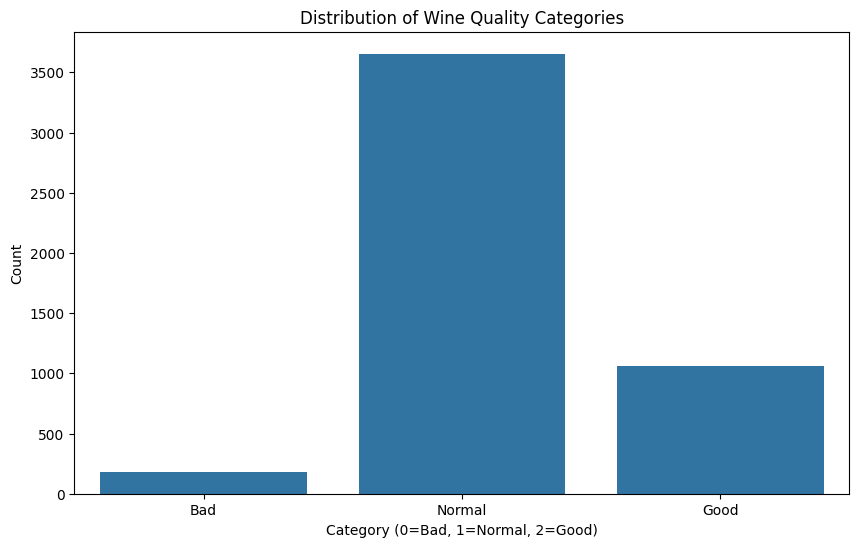

In [ ]:
def encode_quality(quality):
    """
    Encode wine quality into categories as specified in the paper:
    - Bad wine: quality < 5
    - Normal wine: 5 <= quality <= 6
    - Good wine: 7 <= quality <= 10
    """
    if quality < 5:
        return 0  # Bad wine
    elif 5 <= quality <= 6:
        return 1  # Normal wine
    else:  # quality >= 7
        return 2  # Good wine

white_wine['quality_category'] = white_wine['quality'].apply(encode_quality)

# Check distribution after encoding
category_counts = white_wine['quality_category'].value_counts().sort_index()
print("Wine category distribution:")
print(category_counts)

# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='quality_category', data=white_wine)
plt.title('Distribution of Wine Quality Categories')
plt.xlabel('Category (0=Bad, 1=Normal, 2=Good)')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Bad', 'Normal', 'Good'])
plt.show('wine_quality_categories.png')
plt.close()


In [ ]:
#Division of tarjet and explanatory variables
X = white_wine[selected_features]
y = white_wine['quality_category']

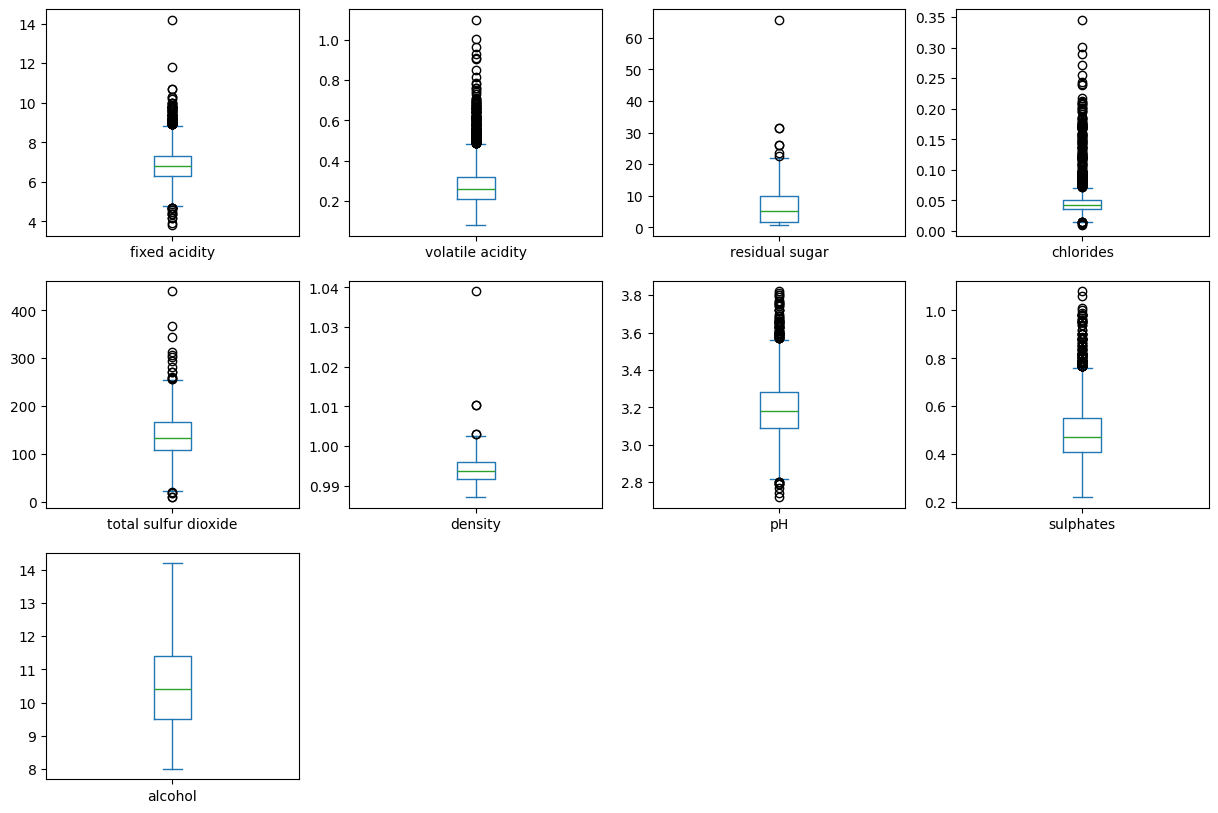

In [ ]:
#Plot boxplot for poitn outliers presence
X.plot(kind='box', subplots=True, layout=(3,4), figsize=(15,10))
plt.show()


In [ ]:
for col in X.columns:  # Iterate over each column in X
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    median = X[col].median()

    # Replace outliers with median
    X[col] = X[col].mask((X[col] < lower_whisker) | (X[col] > upper_whisker), median)

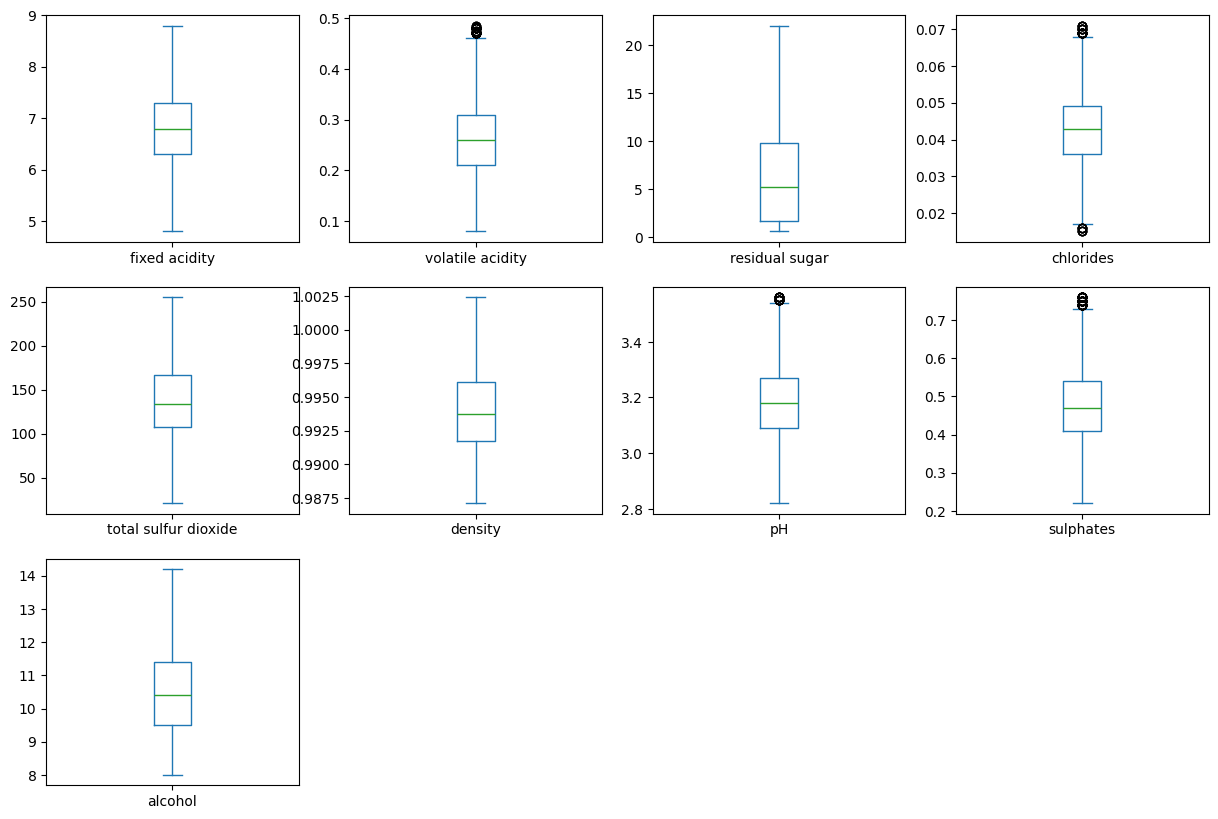

In [ ]:
#Plot boxplot for poitn outliers presence
X.plot(kind='box', subplots=True, layout=(3,4), figsize=(15,10))
plt.show()

In [ ]:
#Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_s, Y_s = smote.fit_resample(X, y)
Y_s.value_counts()

,count
quality_category,
1,3655
2,3655
0,3655


In [ ]:
#Split the data
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(X_s, Y_s, test_size=0.2, random_state=42)
#Scale the data
scaler_r = StandardScaler()
X_train_r_balanced = scaler_r.fit_transform(X_train_balanced)
X_test_r_balanced = scaler_r.transform(X_test_balanced)

# SVM

In [ ]:
#Implement gridserach to unbalanced data to find the best parameters for the SVM model
param = {
    'C': [0.1, 1, 10, 100],       # Regularization parameter
    'gamma': ['scale', 0.01, 0.1, 1],  # Kernel coefficient (RBF only)
    'kernel': ['rbf', 'linear']    # Try different kernels
}
grid = GridSearchCV(SVC(),param_grid=param,cv=5,scoring='accuracy')
grid.fit(X_train_r_balanced, Y_train_balanced)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
#Implementation SVM learning on blanced data with optimized parameters
svc = SVC(C=10,gamma=1,kernel= "rbf" ) #Model building
svc.fit(X_train_r_balanced, Y_train_balanced) #Model Training
Y_svc_pred_balanced_2 = svc.predict(X_test_r_balanced)
print(f"{classification_report(Y_test_balanced, Y_svc_pred_balanced_2)}")

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       688
           1       0.91      0.88      0.89       741
           2       0.91      0.91      0.91       764

    accuracy                           0.92      2193
   macro avg       0.93      0.93      0.93      2193
weighted avg       0.92      0.92      0.92      2193



In [ ]:
rf_param_grid = {
    'n_estimators': [200, 200],
    'max_depth': [20, 20, 20],
    'min_samples_split': [10, 10, 10]
}
rf_original = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    n_jobs=-1
)
rf_original.fit(X_train_r_balanced, Y_train_balanced)

print(f"  Best parameters: {rf_original.best_params_}")
best_rf = rf_original.best_estimator_

y_pred_balanced = best_rf.predict(X_test_r_balanced)
balanced_accuracy = accuracy_score(Y_test_balanced, y_pred_balanced)
print(f"  Accuracy: {balanced_accuracy:.4f}")

print("\n  Classification Report (SMOTE-Balanced Training Data):")
balanced_report = classification_report(Y_test_balanced, y_pred_balanced)
print(balanced_report)

  Best parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
  Accuracy: 0.8997

  Classification Report (SMOTE-Balanced Training Data):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       688
           1       0.89      0.84      0.86       741
           2       0.87      0.91      0.89       764

    accuracy                           0.90      2193
   macro avg       0.90      0.90      0.90      2193
weighted avg       0.90      0.90      0.90      2193



In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # Measure for splitting nodes
    'max_depth': [3, 5, 10, None],     # Tree depth
    'min_samples_split': [2, 5, 10],   # Min samples to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Min samples at a leaf node
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)
grid_search_dt.fit(X_train_r_balanced, Y_train_balanced)
best_dt_model = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=42)
best_dt_model.fit(X_train_r_balanced, Y_train_balanced)
Y_dt_best_pred = best_dt_model.predict(X_test_r_balanced)
print("Optimized Classification Report:\n", classification_report(Y_test_balanced, Y_dt_best_pred))

Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       688
           1       0.81      0.78      0.80       741
           2       0.83      0.82      0.83       764

    accuracy                           0.85      2193
   macro avg       0.85      0.85      0.85      2193
weighted avg       0.84      0.85      0.85      2193

